In [12]:
import torch
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## **Generating new data using the trained model**

In [ ]:
!pip install denoising_diffusion_pytorch

In [25]:
import torch
from tqdm import tqdm
from denoising_diffusion_pytorch import Unet, GaussianDiffusion

In [15]:
import torchvision.utils as utils 
import matplotlib.pyplot as plt

def visualize_samples(model, bts=4):
    model.eval()
    with torch.no_grad():
        samples = diffusion.sample(batch_size=bts).cpu()

    # (C, H, W) to (H, W, C) for matlab
    grid_img = utils.make_grid(samples, nrow=2, normalize=True)
    grid_img = grid_img.permute(1, 2, 0).numpy()

    plt.figure(figsize=(8, 8))
    plt.imshow(grid_img)
    plt.axis("off")
    plt.title(f"Generated Image")
    plt.show()

In [5]:
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    channels = 1,
    flash_attn = True
)

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


In [6]:
model.load_state_dict(torch.load('/kaggle/input/diffusion-model/pytorch/default/1/diffusion_model.pth', weights_only=True))
model.eval()

Unet(
  (init_conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=128, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): RMSNorm()
          (act): SiLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (block2): Block(
          (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): RMSNorm()
          (act): SiLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (res_conv): Identity()
      )
      (2): Line

In [19]:
diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 250    # number of steps
)
diffusion = diffusion.to(device)

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

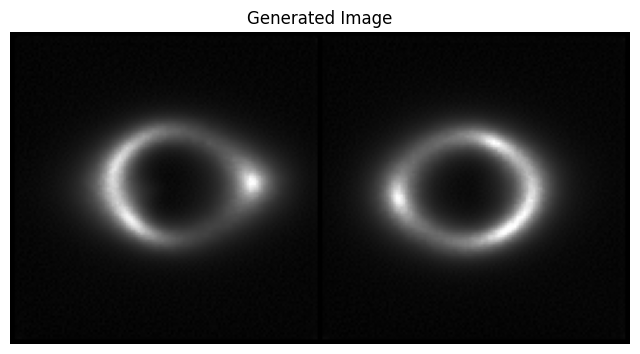

In [20]:
visualize_samples(model, 2) # it works!!

In [22]:
import os
output_dir = "/kaggle/working/generated"
os.makedirs(output_dir, exist_ok=True)

In [24]:
total = 10000 # as there are 10k images in the dataset
bts = 128 # batch size

In [ ]:
for i in tqdm(range(0, total, bts)):
    with torch.no_grad():
        generated_images = diffusion.sample(batch_size=bts)
        
    for j, img in enumerate(generated_images):
        utils.save_image(img, os.path.join(output_dir, f"image_{i+j}.png"), normalize=True)

print("images saved!")

In [41]:
import os
len(os.listdir('/kaggle/working/generated'))

10112

## **Loading the real and generated data into pytorch dataloaders**

In [42]:
real = '/kaggle/input/diffusion-data/Samples'
generated = '/kaggle/working/generated'

In [50]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as TF
from PIL import Image
import numpy as np

In [142]:
class GetDataset(Dataset):
    def __init__(self, folder_path, img_size=128):  # converting images to 128x128 due to limitations on compute
        '''
            Input:
                folder_path - location of the training images 
                img_size - size to which the image must be converted to
        '''
        self.img_size = img_size
        self.folder_path = folder_path
        self.files = [f for f in os.listdir(folder_path)][:10000]
        
    def __getitem__(self, index):
        '''
            Input:
                index - index of the image in the files list

            Output:
                img - resized image tensor
        '''

        file = os.path.join(self.folder_path, self.files[index])

        if file.endswith('.png'):
            img = Image.open(file).convert("L") # extract images as grayscale
            img = np.array(img, dtype=np.float32) / 255 
            img = torch.from_numpy(img).unsqueeze(0)
            
        elif file.endswith('.npy'):
            img = np.load(file).astype(np.float32)
            img = torch.from_numpy(img)
               
        img = TF.resize(img, (self.img_size, self.img_size), antialias=True)
        return img
    
    def __len__(self):  # number of images available in the dataset
        return len(self.files)

In [143]:
real_data = GetDataset(real)
real_loader = DataLoader(real_data, batch_size=64, shuffle=True)
real_loader

In [150]:
# to check the size of each tensor in the dataset
for batch in real_loader:
    print(batch.shape)
    break

torch.Size([64, 1, 128, 128])


In [145]:
generated_data = GetDataset(generated)
generated_loader = DataLoader(generated_data, batch_size=64, shuffle=False)

In [146]:
# to check the size of each tensor in the dataset
for batch in generated_loader:
    first_image = batch[0]
    print(batch.shape)
    break

torch.Size([64, 1, 128, 128])


(-0.5, 127.5, 127.5, -0.5)

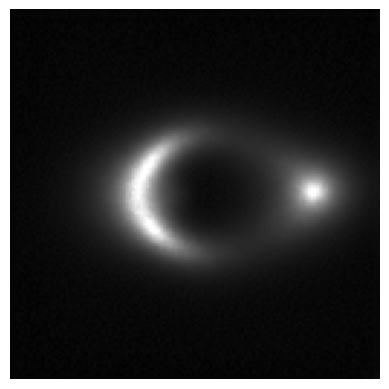

In [147]:
first_image = first_image.permute(1, 2, 0)
plt.imshow(first_image.numpy(), cmap="gray" if first_image.shape[-1] == 1 else None)
plt.axis("off")

In [148]:
np.min(first_image.numpy()),np.max(first_image.numpy())

(0.0, 1.0)

## **Comparison Metrics**

In [ ]:
!pip install pytorch-ignite

reference: https://github.com/mseitzer/pytorch-fid and https://pytorch-ignite.ai/blog/gan-evaluation-with-fid-and-is/

In [212]:
import torch
import torch.nn as nn
from ignite.metrics import FID
from ignite.metrics import Precision, Recall
from ignite.engine import Engine
from tqdm import tqdm

In [109]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [211]:
def eval_step(engine, batch):
    generated_images, real_images = batch
    return generated_images.to(device), real_images.to(device)
    
evaluator = Engine(eval_step)

### **Fréchet Inception Distance (FID)**

Using ResNet model (from common task) for feature extraction hence the fully connected layer is removed

In [117]:
class ResNet(nn.Module):
    def __init__(self, block, layers):
        '''
            Input:
                block - residual block class
                layers - number of residual blocks in each of the four layers
        '''
        super(ResNet, self).__init__()
        self.inplanes = 64

        # initial layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # layers of residual blocks
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def _make_layer(self, block, planes, blocks, stride=1):
        '''
            Input:
                block - residual block class
                planes - number of output channels of the layer (number of filters)
                blocks - number of residual blocks in the layer
                stride - to control downsampling

            Output:
                all blocks are combined into an nn.Sequential module
        '''
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        '''
            Input:
                x - image tensor with (batch size, channels, height, width)

            Output:
                x - (batch size, number of output classes), raw logit values
        '''
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x     # 512 dimensional vector

In [118]:
class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
            '''
                Input:
                    in_channels - number of input channels
                    out_channels - number of output channels
                    stride - controls downsampling, for the first convolution
                    downsample - downsampling layer to match dimenstions for skip connection
            '''

            super(ResidualBlock, self).__init__()
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True))
            self.conv2 = nn.Sequential(
                            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias=False),
                            nn.BatchNorm2d(out_channels))
            self.downsample = downsample
            self.relu = nn.ReLU(inplace=True)
            self.out_channels = out_channels

        def forward(self, x):
            '''
                Input:
                    x - image tensor with (batch size, input channels, height, width)

                Output:
                    x - (batch size, output channels, new height, new width) 
            '''
            residual = x
            out = self.conv1(x)
            out = self.conv2(out)
            if self.downsample:
                residual = self.downsample(x)
            out += residual
            return self.relu(out)

In [ ]:
feature_extractor = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
feature_extractor.eval()

In [ ]:
fid_metric = FID(num_features=512, feature_extractor=feature_extractor, device=device)
# number of features from the resnet model is 512

In [168]:
fid_metric.attach(evaluator, "fid")

In [ ]:
evaluator.run(zip(generated_loader, real_loader))

State:
	iteration: 157
	epoch: 1
	epoch_length: 157
	max_epochs: 1
	output: <class 'NoneType'>
	batch: <class 'NoneType'>
	metrics: <class 'dict'>
	dataloader: <class 'zip'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [171]:
fid_score = evaluator.state.metrics["fid"]
print("FID Score:", fid_score)

FID Score: 0.0009522687934785418


### **Renyi Kernel Entropy**

https://github.com/mjalali/renyi-kernel-entropy

In [ ]:
!pip install rke-score

In [228]:
from rke_score import RKE

In [225]:
def extract_features(dataloader, model):
    features = []
    model.to(device)
    
    with torch.no_grad():
        for images in dataloader: 
            images = images.to(device)
            feature_vectors = model(images)
            features.append(feature_vectors.cpu().numpy())
    return np.vstack(features)  

In [226]:
real_features = extract_features(real_loader, feature_extractor)
generated_features = extract_features(generated_loader, feature_extractor)

In [ ]:
kernel = RKE(kernel_bandwidth=[0.2, 0.3, 0.4])

In [230]:
print(kernel.compute_rke_mc(generated_features))
print(kernel.compute_rrke(real_features, generated_features))

{0.2: 1.0261691817562502, 0.3: 1.0116372548484103, 0.4: 1.0065493815757378}
{0.2: 0.025132607651035647, 0.3: 0.0113372504605527, 0.4: 0.0064108677585926815}


RKE or Renyi Kernel Entropy values for the generated features is close to 1 so there is high entropy

RRKE or Renyi Kernel Entropy between the real and generated features is very small, showing that they are fairly similar, and as the bandwidth increases the entropy reduces